In [28]:
import torch
import matplotlib.pyplot as plt
import numpy as np

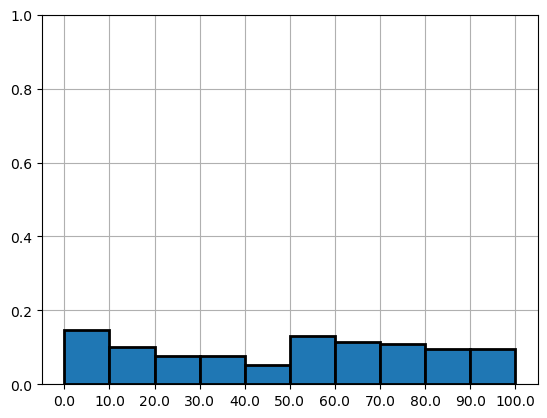

In [144]:
n_bins = 10
bin_boundaries = torch.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

b = np.random.dirichlet(np.ones(n_bins)*10,size=1)[0]
bars = np.arange(0,100+100*bin_uppers[0],100/n_bins)
bars = [str(bar) for bar in bars]
xpos = np.arange(0,n_bins+1)
xtickpos = [xpos[i]-0.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.bar(xpos[:-1],b,width=1,edgecolor='black',linewidth=2)
plt.xticks(xtickpos,bars)
plt.ylim([0,1])
plt.grid()

In [194]:
means = bin_uppers-bin_uppers[0]/2
std = 0.05
accs = torch.normal(means,std).abs()
accs = [2-acc if acc > 1 else acc for acc in accs]
accs

[tensor(0.0115),
 tensor(0.0798),
 tensor(0.1816),
 tensor(0.4713),
 tensor(0.3670),
 tensor(0.4955),
 tensor(0.6283),
 tensor(0.7854),
 tensor(0.8975),
 tensor(0.9793)]

In [147]:
means

tensor([0.0500, 0.1500, 0.2500, 0.3500, 0.4500, 0.5500, 0.6500, 0.7500, 0.8500,
        0.9500])

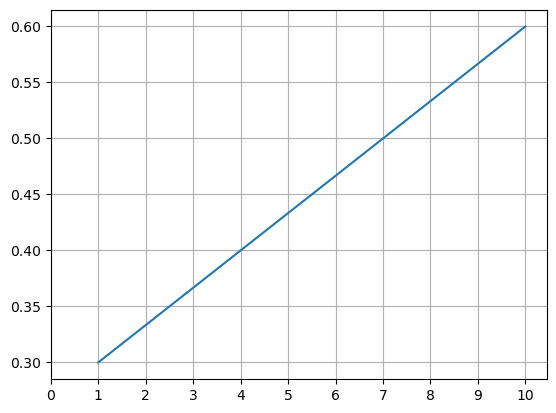

In [204]:
x = np.linspace(0,1,100)
cost = x + (1-x)*10
accuracy = 0.3*x + 0.6*(1-x)
plt.plot(cost,accuracy)
plt.xticks(np.arange(0,11))
plt.grid()


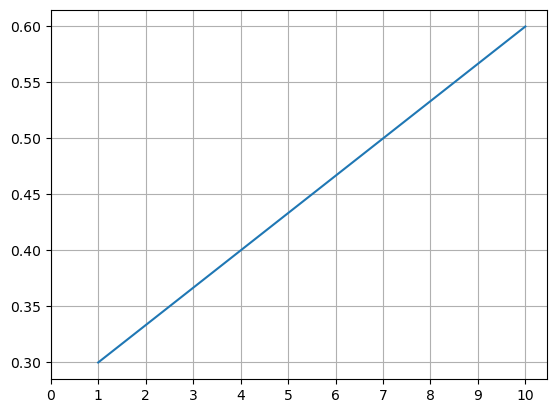

In [206]:
from mpl_toolkits import mplot3d
x_d1 = np.linspace(0,0.5,100)
x_d2 = np.linspace(0,0.5,100)
cost = x_d1 + (0.5-x_d1)*10 + x_d2 + (0.5-x_d2)*10
accuracy = 0.2*x_d1 + 0.4*(0.5-x_d1) + 0.4*x_d2 + 0.8*(0.5-x_d2)
plt.plot(cost,accuracy)
plt.xticks(np.arange(0,11))
plt.grid()